In [1]:
import torch
import pickle
import numpy as np
import sys
sys.path.append('./../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML
from matplotlib import style
#rc('animation', html='html5')

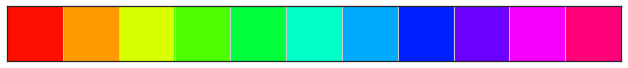

In [3]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

current_palette = sns.color_palette(sns.hls_palette(10+1, l=.5, s=1.0))
#current_palette = sns.color_palette(sns.hls_palette(21+1, l=.5, s=1.0))

sns.palplot(current_palette)


In [4]:
from utility.dataset import _process_Synthetic
from models_utility.construct_models import _combine_models
from utility.eval_metric import _measure_metric, accuracy, compute_bic
#torch.set_default_tensor_type(torch.FloatTensor)


file_path = './dataset/synthetic/'
file_name = 'Q6_Fs200'
data_file_path = file_path + file_name


##############################################################################
# load dataset
##############################################################################
random_seed = 1000
num_exp = 1


###############################################
###############################################

exp_setting = {}
exp_setting['device'] = False

exp_setting['num_rep_exp'] = num_exp
exp_setting['data'] = file_name
exp_setting['full_length'] = 100

exp_setting['input_dim'] = 1
exp_setting['Num_HiddenState'] = 8
exp_setting['Num_Q'] = 4



# x_train, y_train, z_train, x_test,y_test,z_test, true_freq , true_weight , true_noise_level ,true_num_state = _process_Synthetic(data_file_path,exp_setting)

# exp_setting['input_length'] = x_train.shape[1]
# z_test -= 1
# z_train -= 1


x_train, y_train, z_train, x_test, y_test, z_test, \
true_freq, true_weight, true_noise_level, true_num_state = _process_Synthetic(data_file_path, exp_setting)
exp_setting['input_length'] = x_train.shape[1]


In [5]:
print('#' * 100)
print('(#sequences, #time-series observations)')
print('xtrain.shape {}, ytrain.shape {}, xtest.shape {}, ytest.shape {}'.format(x_train.shape,y_train.shape,x_test.shape,y_test.shape))

####################################################################################################
(#sequences, #time-series observations)
xtrain.shape (100, 200), ytrain.shape (100, 200), xtest.shape (50, 200), ytest.shape (50, 200)


In [6]:
###############################################################################################
# Model Setting
###############################################################################################

HMMGP_setting = {}
HMMGP_setting['emission'] = 'gpsm' #
HMMGP_setting['train'] = 'SVI' #


HMMGP_setting['Num_Q'] = exp_setting['Num_Q']
HMMGP_setting['lr_A'] = 0.05
HMMGP_setting['lr_pi'] = 0.05
HMMGP_setting['lr_hyp'] = 0.005


HMMGP_setting['Len_Full'] = exp_setting['full_length']
if HMMGP_setting['train'] == 'VBEM':
    HMMGP_setting['Len_Batch'] = HMMGP_setting['Len_Full']
    HMMGP_setting['Num_Batch'] = 1
else:
    HMMGP_setting['Len_Batch'] = 10
    HMMGP_setting['Num_Batch'] = 1


HMMGP_setting['device'] = exp_setting['device']


HMMGP_setting['Iter_train'] = 40 #for beta
HMMGP_setting['Iter_hyp'] = 10 #for beta
HMMGP_setting['Rate_RRFFSpectralPt'] = 1.0



HMMGP_setting['Num_RRFFSpectralPt_total'] = int ( (exp_setting['input_length']*HMMGP_setting['Rate_RRFFSpectralPt']) )
HMMGP_setting['Num_RRFFBatch'] = 1
HMMGP_setting['Num_K_Emission'] = 1



In [7]:
print('model: hmmgpsm(Q={}), infer: {}+{}, #full-sequences:{}, #sub-sequences: {}'.format(HMMGP_setting['Num_Q'],
                                                                                                    HMMGP_setting['train'],
                                                                                                    HMMGP_setting['emission'],
                                                                                                    HMMGP_setting['Len_Full'],
                                                                                                    HMMGP_setting['Len_Batch']) )


num_emission_param = exp_setting['Num_HiddenState']*(exp_setting['Num_Q']*(3*exp_setting['input_dim']) + 1 )
num_trasition_param = exp_setting['Num_HiddenState']**2 + exp_setting['Num_HiddenState']
num_modelparam = num_emission_param + num_trasition_param 
print('#model param : {}'.format(num_modelparam))

print('')

model: hmmgpsm(Q=4), infer: SVI+gpsm, #full-sequences:100, #sub-sequences: 10
#model param : 176



## build the model and intialize the hyperparameters

In [8]:
model = _combine_models(x_train, y_train, exp_setting, HMMGP_setting,random_seed=random_seed,num_init_iter = 251)  

21
0 emission, 0 iter, loss 46.6707 
0 emission, 50 iter, loss -7.2852 
0 emission, 100 iter, loss -32.5095 
0 emission, 150 iter, loss -51.0167 
0 emission, 200 iter, loss -64.4438 
0 emission, 250 iter, loss -74.0769 

1
1 emission, 0 iter, loss 45.0238 
1 emission, 50 iter, loss 10.2474 
1 emission, 100 iter, loss -26.7250 
1 emission, 150 iter, loss -43.1874 
1 emission, 200 iter, loss -52.8787 
1 emission, 250 iter, loss -63.2968 

8
2 emission, 0 iter, loss 81.6108 
2 emission, 50 iter, loss 22.1744 
2 emission, 100 iter, loss -11.6128 
2 emission, 150 iter, loss -29.1991 
2 emission, 200 iter, loss -43.2705 
2 emission, 250 iter, loss -54.9861 

0
3 emission, 0 iter, loss 119.7522 
3 emission, 50 iter, loss 43.3213 
3 emission, 100 iter, loss 12.9873 
3 emission, 150 iter, loss -9.5013 
3 emission, 200 iter, loss -26.0510 
3 emission, 250 iter, loss -35.0207 

2
4 emission, 0 iter, loss 118.0574 
4 emission, 50 iter, loss 16.5980 
4 emission, 100 iter, loss -0.8228 
4 emission, 

## train the model

In [9]:
# for i_th in range(exp_setting['num_rep_exp']):    
#     model = _combine_models(x_train, y_train, exp_setting, HMMGP_setting,random_seed=random_seed,num_init_iter = 251)
    
#     loglik_list, train_accuracy_list, test_accuracy_list, \
#     time_list, num_cluster_list, param_history_dict = model.train(x_train, y_train, z_train, x_test, y_test, z_test)


#     print('#' * 100)

#     tr_elbo, tr_lik, te_elbo, te_lik = loglik_list[:,0], loglik_list[:,1], loglik_list[:,2], loglik_list[:,3]
#     tr_bic = compute_bic(x_train,y_train,tr_lik[-1],num_modelparam)
#     te_bic = compute_bic(x_test,y_test,te_lik[-1],num_modelparam)



  
loglik_list, train_accuracy_list, test_accuracy_list, time_list, param_history_dict, z_pred_list  = model.train(x_train, y_train, z_train, x_test, y_test, z_test)

----------------------------------------------------------------------------------------------------
iter 1, iteration time : 21.697| train acc : 0.530, train lik : -113697.630, 	 test acc : 0.580, test lik : -23819.024 |e train acc : 0.530, e train lik : -113697.630 e test acc : 0.580, e test lik : -23819.024 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
iter 5, iteration time : 21.124| train acc : 0.520, train lik : -73443.217, 	 test acc : 0.480, test lik : -14907.577 |e train acc : 0.520, e train lik : -73443.217 e test acc : 0.480, e test lik : -14907.577 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
iter 10, iteration time : 20.863| train acc : 0.580, train lik : 5860.709

In [86]:
train_accuracy_list, test_accuracy_list

(array([[0.53, 0.53],
        [0.52, 0.52],
        [0.58, 0.58],
        [0.68, 0.68],
        [0.72, 0.72],
        [0.71, 0.71],
        [0.72, 0.72],
        [0.7 , 0.7 ],
        [0.67, 0.67]]), array([[0.58, 0.58],
        [0.48, 0.48],
        [0.62, 0.62],
        [0.7 , 0.7 ],
        [0.7 , 0.7 ],
        [0.7 , 0.7 ],
        [0.7 , 0.7 ],
        [0.74, 0.74],
        [0.72, 0.72]]))

## metric

In [85]:
tr_elbo, tr_lik, te_elbo, te_lik = loglik_list[:,0], loglik_list[:,1], loglik_list[:,2], loglik_list[:,3]
tr_bic = compute_bic(x_train,y_train,tr_lik[-1],num_modelparam)
te_bic = compute_bic(x_test,y_test,te_lik[-1],num_modelparam)
z_train_pred,z_test_pred = z_pred_list[-1]
revised_order_dict, revised_z_test_pred, _ = _measure_metric(z_test, z_test_pred)

[-390372.66934793 -323706.337509   -231752.58812485 -207060.23378548
 -172859.74427824 -174755.31271054 -187993.95116183 -172880.7074526
 -194919.03514571] [-113697.62976637  -73443.21659372    5860.70864691   23677.17065028
   70655.99343389   74795.91119112   79730.55216249   89180.35045843
   62766.34913948] [-163422.01506155 -140718.4917261  -119438.14713916 -108088.89555274
 -108347.86458777 -103768.34296313 -112349.86899122 -106418.19926934
 -118026.62103703] [-23819.02391393 -14907.57746518    -28.23035129   8374.85155985
  14497.18218949  22248.2161525   22957.88330462  26024.27979485
  14309.36207708]


In [66]:
figsiz2 = (20,2) 
labelsiz = 15
fontsiz = 20
interval = 0.2
xlimit_range = [110,140]

## test set

No handles with labels found to put in legend.


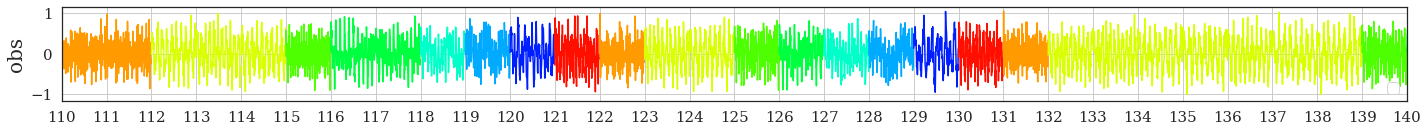

In [67]:

fig = plt.figure(figsize = figsiz2 )
for ith,(ith_x,ith_y,ith_z) in enumerate(zip(x_test,y_test,z_test)):
    plt.plot(ith_x , ith_y , color = current_palette[ith_z])

plt.tick_params(labelsize=labelsiz) 
plt.xlim(xlimit_range)

plt.ylabel('obs',fontsize = fontsiz)
#plt.xlabel('time',fontsize = fontsiz)

plt.yticks(fontsize = 15)
plt.xticks(np.arange(xlimit_range[0],xlimit_range[1]+1),fontsize = 15 )

#plt.xlabel('log10 training time (sec)',fontsize = fontsiz)
plt.legend(loc='lower right',fontsize = 15)
fig.tight_layout()    

plt.show()



## estimation for test set

No handles with labels found to put in legend.


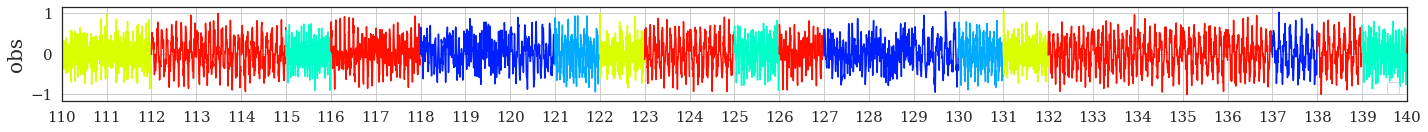

In [68]:
fig = plt.figure(figsize = figsiz2 )
for ith,(ith_x,ith_y,ith_z) in enumerate( zip(x_test,y_test,revised_z_test_pred)):
    plt.plot(ith_x , ith_y , color = current_palette[ith_z])

#    plt.plot( ith_x, ith_y , color = current_palette[ith_z])

plt.tick_params(labelsize=labelsiz) 
plt.xlim(xlimit_range)

plt.ylabel('obs',fontsize = fontsiz)
# plt.xlabel('time',fontsize = fontsiz)
plt.xticks(np.arange(xlimit_range[0],xlimit_range[1]+1),fontsize = 15 )
plt.yticks(fontsize = 15)

#plt.xlabel('log10 training time (sec)',fontsize = fontsiz)
plt.legend(loc='lower right',fontsize = 15)
fig.tight_layout()    

#plt.savefig(save_figure_path + model_name + '_pred'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()


## accuracy 
Here, the HMMGPSM is trained by SVI.

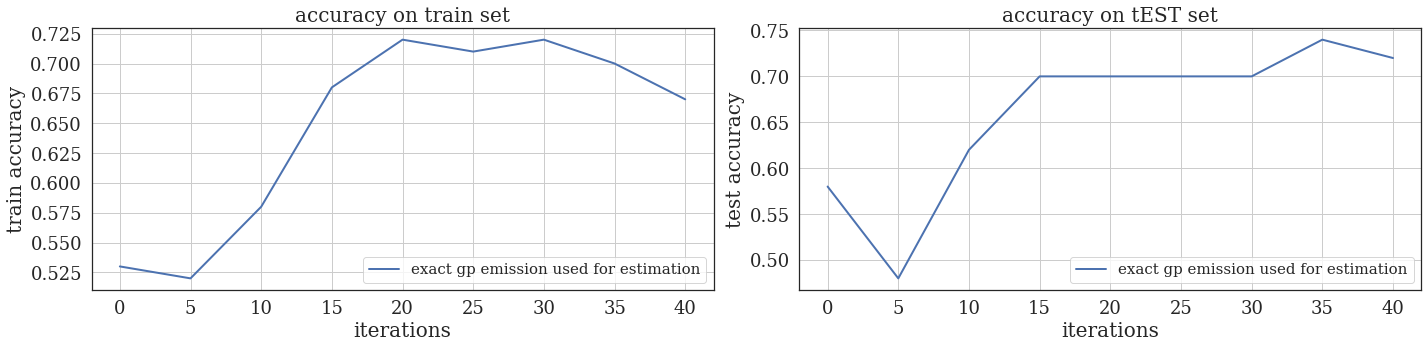

In [83]:
iters = np.arange(HMMGP_setting['Iter_train']+1)[::5]

figsiz = (20,5) 
#figsiz = (6,4) 
labelsiz = 15
fontsiz = 15
interval = 0.2


fig = plt.figure(figsize = figsiz)
plt.subplot(1,2,1)

# plt.plot(time_list.cumsum(),train_accuracy_list[:,0])
# plt.xlabel('time (sec)',fontsize = 20)

plt.plot(iters ,train_accuracy_list[:,0],label='exact gp emission used for estimation',linewidth=2)
plt.xlabel('iterations',fontsize = 20)


plt.ylabel('train accuracy',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('accuracy on train set',fontsize=20)



plt.subplot(1,2,2)

plt.plot(iters ,test_accuracy_list[:,0],label='exact gp emission used for estimation',linewidth=2)
plt.xlabel('iterations',fontsize = 20)


plt.ylabel('test accuracy',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('accuracy on tEST set',fontsize=20)

fig.tight_layout()    
plt.show()
